In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from scipy import signal
from pathlib import Path
from src.data.file_utils import GetTV

In [3]:
def nearest_index(array, value):
    """Find the index of the nearest value in an array."""
    return (np.abs(array - value)).argmin()

def crop_time(times, data, start_time, end_time):
    """Crop the data to the specified time range."""
    start_idx = nearest_index(times, start_time)
    end_idx = nearest_index(times, end_time)
    return times[start_idx:end_idx], data[:,start_idx:end_idx]

In [4]:
def get_error(ze, zx, zs):
    return (zx - ze) / (ze - zs)

In [5]:
mdl_path = "../models/lr_coef.txt"  # Replace with your file path

with open(mdl_path, "r") as file:
    coef = file.readlines()

mdl_path = "../models/lr_intercept.txt"  # Replace with your file path

with open(mdl_path, "r") as file:
    inter = file.readlines()
    
coef_ = np.array([float(i) for i in coef])
inter_ = np.array([float(i) for i in inter])
r_coef_ = coef_[:len(coef_)//2]
z_coef_ = coef_[len(coef_)//2:]

In [112]:
shot_idx = 2

In [113]:
data_path = "../data/raw/tv_images/l-mode"
tv = GetTV(data_path)
files = tv.list_files()
files = sorted(files, key=lambda x: int(Path(x).stem.split('_')[-1]))
radii = tv.load(files[shot_idx], 'radii')[0]
elevation = tv.load(files[shot_idx], 'elevation')[0]
vid_shape = tv.load(files[shot_idx], 'vid')[0].shape
vid_times = tv.load(files[shot_idx], 'vid_times')

In [114]:
frames = tv.load(files[shot_idx], 'vid')
print("Extracting video:", files[shot_idx].stem)
frames_reshape = frames.reshape(len(frames), -1)

Extracting video: emission_structure_pu_cam240perp_190113


In [115]:
print(frames_reshape.shape)

(420, 172800)


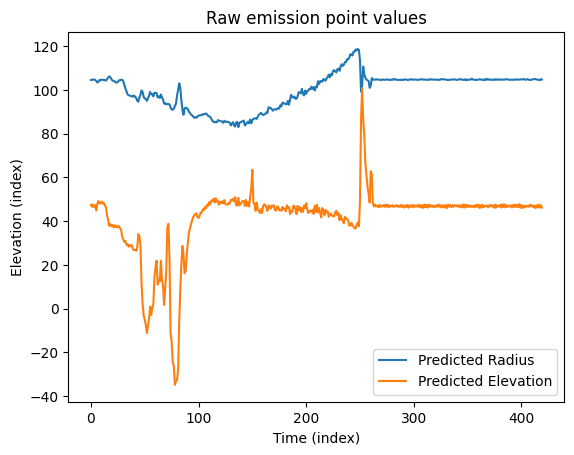

In [116]:
# example index 1
pred_r = np.dot(frames_reshape, r_coef_) + inter_[0] # left half
pred_z = np.dot(frames_reshape, z_coef_) + inter_[1] # right half
plt.plot(pred_r, label = "Predicted Radius")
plt.plot(pred_z, label = "Predicted Elevation")
plt.ylabel("Elevation (index)")
plt.xlabel("Time (index)")
plt.legend()
plt.title("Raw emission point values")
plt.show()

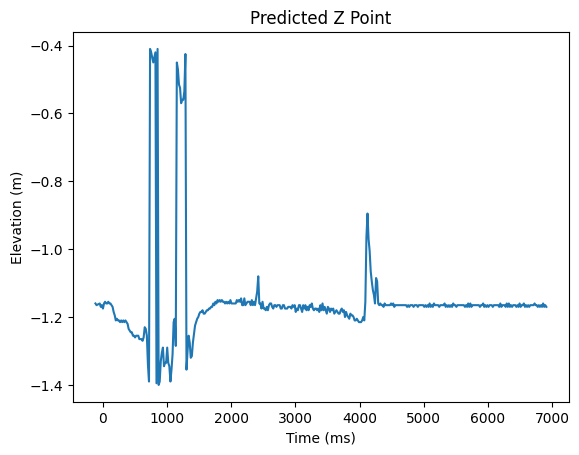

In [117]:
real_pred_r = radii[np.round(pred_r).astype(int)]
real_pred_z = elevation[np.round(pred_z).astype(int)]
plt.ylabel("Elevation (m)")
plt.xlabel("Time (ms)")
plt.plot(vid_times,real_pred_z)
plt.title("Predicted Z Point")
plt.show()

In [118]:
pkl_path = '../data/external/toksearch/detach.pkl'

with open(pkl_path, 'rb') as file:
    points = pickle.load(file)
    
point_keys = list(points.keys())
shot = points[point_keys[shot_idx]]['vars']
times = points[point_keys[shot_idx]]['time']
times_transp = np.transpose(times)
shot_transp = np.transpose(shot)
print(point_keys)
print("Extracting pkl for shot: ", point_keys[shot_idx])

[190109, 190110, 190113, 190114, 190115, 190116]
Extracting pkl for shot:  190113


In [119]:
h5_path = '../data/external/toksearch/detach.h5'

with h5py.File(h5_path, 'r') as file:
    keys = list(file.keys())

In [120]:
with h5py.File(h5_path, 'r') as file:
    shot = file[keys[shot_idx]]
    print("Extracting h5 for shot: ", keys[shot_idx])
    if 't_ip_flat_sql' in shot:
        t_ip_flat = shot['t_ip_flat_sql'][()]
        print('t_ip_flat:', t_ip_flat)
    else:
        print("t_ip_flat_sql not found in h5 file.")
    if 'ip_flat_duration_sql' in shot:
        ip_flat_duration = shot['ip_flat_duration_sql'][()]
        print('ip_flat_duration:', ip_flat_duration)
    else:
        print("ip_flat_duration_sql not found in h5 file.")

Extracting h5 for shot:  190113
t_ip_flat: 1064.47998046875
ip_flat_duration: 2984.75


In [121]:
crop_times, crop_shot = crop_time(times_transp, shot_transp, t_ip_flat, ip_flat_duration)
crop_times_vid, crop_pred_z = crop_time(vid_times, np.expand_dims(real_pred_z, axis=0), t_ip_flat, ip_flat_duration)
zx = crop_shot[1] / 1e2
zs = crop_shot[3] / 1e2
ze = crop_pred_z[0]

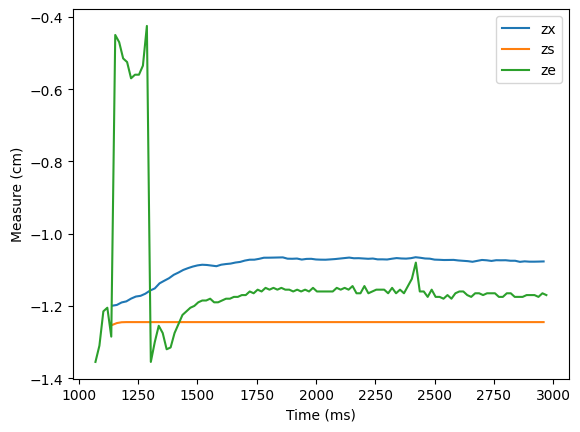

In [122]:
# plt.plot(crop_times, crop_shot[0], label="rx")
plt.plot(crop_times, zx, label="zx")
# plt.plot(crop_times, crop_shot[2], label="rs")
plt.plot(crop_times, zs, label="zs")
plt.plot(crop_times_vid, ze, label="ze")
plt.xlabel("Time (ms)")
plt.ylabel("Measure (cm)")
plt.legend()
plt.show()

In [123]:
ze_up = signal.resample(ze, len(zx))
zx_down = signal.resample(zx, len(ze))
zs_down = signal.resample(zs, len(ze))

In [124]:
err_up = get_error(ze_up, zx, zs)
err_down = get_error(ze, zx_down, zs_down)

Text(0.5, 1.0, 'ze')

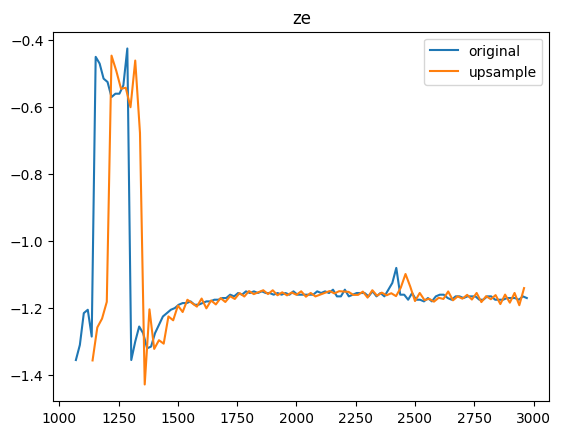

In [125]:
plt.plot(crop_times_vid, ze, label='original')
plt.plot(crop_times, ze_up, label='upsample')
plt.legend()
plt.title("ze")

Text(0.5, 1.0, 'zx')

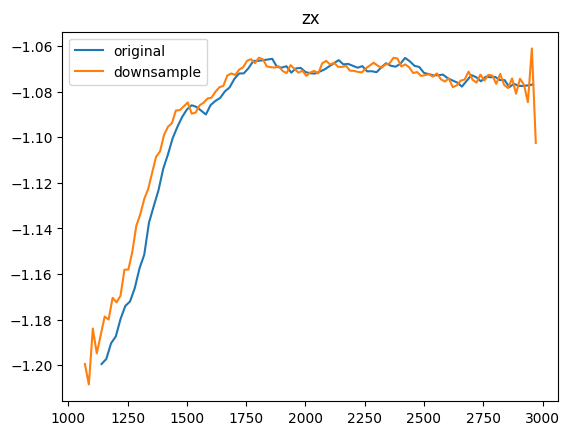

In [126]:
plt.plot(crop_times, zx, label='original')
plt.plot(crop_times_vid, zx_down, label='downsample')
plt.legend()
plt.title("zx")

Text(0.5, 1.0, 'zs')

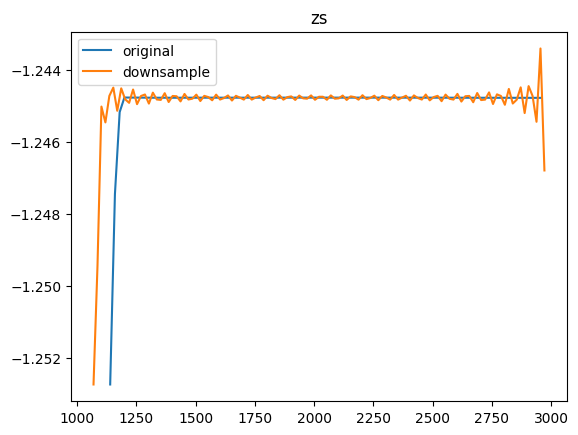

In [127]:
plt.plot(crop_times, zs, label='original')
plt.plot(crop_times_vid, zs_down, label='downsample')
plt.legend()
plt.title("zs")

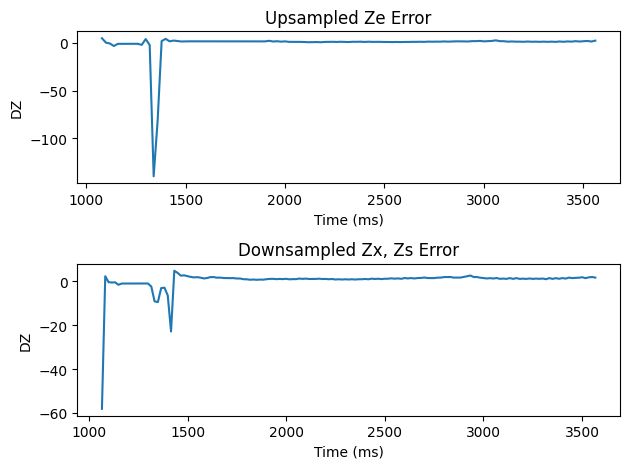

In [101]:
plt.subplot(2, 1, 1)
plt.plot(crop_times, err_up, label="Error up")
plt.xlabel("Time (ms)")
plt.ylabel("DZ")
plt.title("Upsampled Ze Error")
plt.subplot(2, 1, 2)
plt.plot(crop_times_vid, err_down, label="Error down")
plt.xlabel("Time (ms)")
plt.ylabel("DZ")
plt.title("Downsampled Zx, Zs Error")
plt.tight_layout()
plt.show()